# 0:前提（設定）

* クライアント：生命保険会社？
* 依頼内容：タイタニック号に乗船した約1300人のうち、約900人の生死は判明している。残り約400人の生死が知りたい。

# 1:受領データの確認
* train.csv
    * 生死が判明している約900人の乗客データ
    * このデータを元に、生死が判明していない約400人の生死を判断する
* test.csv
    * 生死が判明していない約400人の乗客データ
    * この約400人の乗客の、生死が知りたい
* gender_submission.csv
    * 納品データサンプル
    * このデータの形式で、クライアントに納品する

In [1]:
# インポート
import numpy as np
import pandas as pd

# ファイルの読み込み
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
submit = pd.read_csv('input/gender_submission.csv')

## 1-1:それぞれのファイルの先頭5行を確認する

In [2]:
# 先頭5行確認(train.csv)
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
# 先頭5行確認(test.csv)
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [4]:
# 同様にsubmit.csvの先頭5行確認
submit.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

## 1-2:それぞれのファイルのカラムを確認する

In [5]:
# レコード数、カラム数の確認
print(train.shape)
print(test.shape)
print(submit.shape)

(891, 12)
(418, 11)
(418, 2)


In [6]:
# カラム名の確認
print(train.columns)
print(test.columns)
print(submit.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Survived'], dtype='object')


In [7]:
# カラム毎の要約
train.info()
test.info()
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [8]:
# 欠損値の確認
print(train.isnull().sum())
print(test.isnull().sum())
print(submit.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
PassengerId    0
Survived       0
dtype: int64


# 1-3:全員分（trainとtestをあわせたもの）のデータを確認する

In [9]:
# trainとtestを縦に連結
df_full = pd.concat([train, test], axis=0, sort=False)

In [10]:
# 行数と列数を確認
df_full.shape

(1309, 12)

In [11]:
# 基本統計量の確認（数値型）
df_full.describe()

PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max       9.000000   512.329200

In [12]:
# 基本統計量の確認(オブジェクト型)
df_full.describe(include = 'O')

Name   Sex    Ticket        Cabin Embarked
count               1309  1309      1309          295     1307
unique              1307     2       929          186        3
top     Kelly, Mr. James  male  CA. 2343  C23 C25 C27        S
freq                   2   843        11            6      914

# 1-4:train.csvを可視化する

In [13]:
# インポート
import pandas_profiling as pdp

# レポートの作成
pdp.ProfileReport(train)

In [14]:
# インポート
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

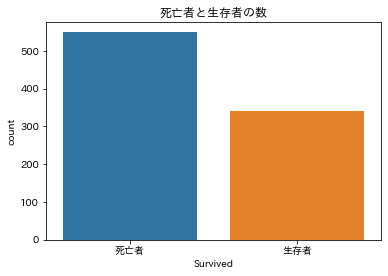

0    549
1    342
Name: Survived, dtype: int64

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [15]:
# 生存者、死亡者の可視化
sns.countplot(x='Survived', data=train)
plt.title('死亡者と生存者の数')
plt.xticks([0, 1],['死亡者', '生存者'])
plt.show()

# 死亡者と生存者数を表示する
display(train['Survived'].value_counts())

# 死亡者と生存者の割合を表示する
display(train['Survived'].value_counts()/len(train['Survived']))

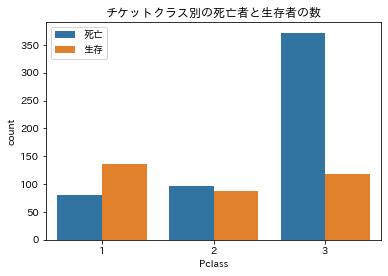

Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Survived         0         1
Pclass                      
1         0.370370  0.629630
2         0.527174  0.472826
3         0.757637  0.242363

In [16]:
# チケットクラス別の生存者数を可視化
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title('チケットクラス別の死亡者と生存者の数')
plt.legend(['死亡', '生存'])
plt.show()

# PclassとSurvivedをクロス集計する
display(pd.crosstab(train['Pclass'], train['Survived']))

# クロス集計しPclassごとに正規化する
display(pd.crosstab(train['Pclass'], train['Survived'], normalize='index'))

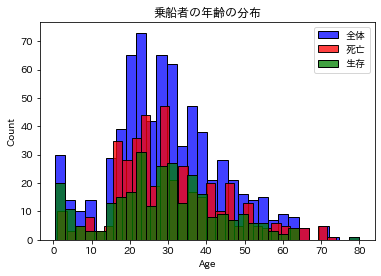

In [17]:
# 年齢別のヒストグラム
sns.histplot(train['Age'].dropna(), kde=False, bins=30, label='全体', color='blue')
sns.histplot(train[train['Survived'] == 0].Age.dropna(), kde=False, bins=30,
label='死亡', color='red')
sns.histplot(train[train['Survived'] == 1].Age.dropna(), kde=False, bins=30,
label='生存', color='green')

plt.title('乗船者の年齢の分布')
plt.legend()

In [18]:
# 年齢を８等分し、CategoricalAgeという変数を作成
train['CategoricalAge'] = pd.cut(train['Age'], 8)
# CategoricalAgeとSurvivedをクロス集計する
display(pd.crosstab(train['CategoricalAge'], train['Survived']))
# クロス集計しCategoricalAgeごとに正規化する
display(pd.crosstab(train['CategoricalAge'], train['Survived'],
normalize='index'))

Survived            0   1
CategoricalAge           
(0.34, 10.368]     26  38
(10.368, 20.315]   71  44
(20.315, 30.263]  146  84
(30.263, 40.21]    86  69
(40.21, 50.158]    53  33
(50.158, 60.105]   25  17
(60.105, 70.052]   13   4
(70.052, 80.0]      4   1

Survived                 0         1
CategoricalAge                      
(0.34, 10.368]    0.406250  0.593750
(10.368, 20.315]  0.617391  0.382609
(20.315, 30.263]  0.634783  0.365217
(30.263, 40.21]   0.554839  0.445161
(40.21, 50.158]   0.616279  0.383721
(50.158, 60.105]  0.595238  0.404762
(60.105, 70.052]  0.764706  0.235294
(70.052, 80.0]    0.800000  0.200000

Text(0.5, 1.0, '同乗している兄弟・配偶者の数')

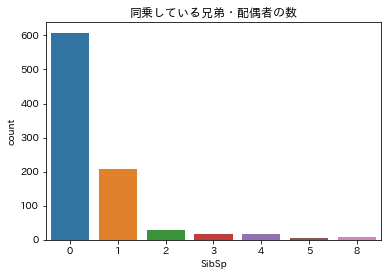

In [19]:
sns.countplot(x='SibSp', data=train)
plt.title('同乗している兄弟・配偶者の数')

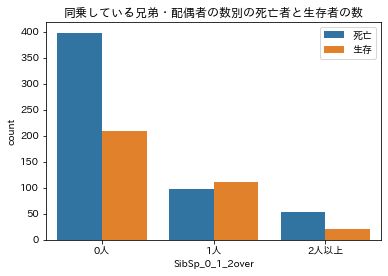

Survived           0    1
SibSp_0_1_2over          
0                398  210
1                 97  112
2                 54   20

Survived                0         1
SibSp_0_1_2over                    
0                0.654605  0.345395
1                0.464115  0.535885
2                0.729730  0.270270

In [20]:
# SibSpが0か1であればそのまま、2以上であれば2である特徴量SibSp_0_1_2overを作成
train['SibSp_0_1_2over'] = [i if i <=1 else 2 for i in train['SibSp']]
# SibSp_0_1_2overごとに集計し、可視化
sns.countplot(x='SibSp_0_1_2over', hue='Survived', data=train)
plt.legend(['死亡', '生存'])
plt.xticks([0,1,2], ['0人', '1人', '2人以上'])
plt.title('同乗している兄弟・配偶者の数別の死亡者と生存者の数')
plt.show()
# SibSpとSurvivedをクロス集計する
display(pd.crosstab(train['SibSp_0_1_2over'], train['Survived']))
# クロス集計しSibSpごとに正規化する
display(pd.crosstab(train['SibSp_0_1_2over'], train['Survived'],
normalize='index'))

Text(0.5, 1.0, '同乗している両親・子供の数')

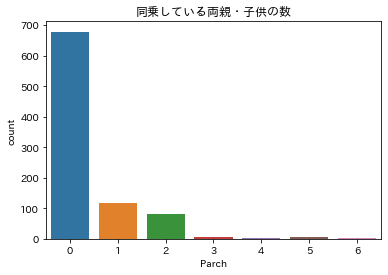

In [21]:
sns.countplot(x='Parch', data=train)
plt.title('同乗している両親・子供の数')

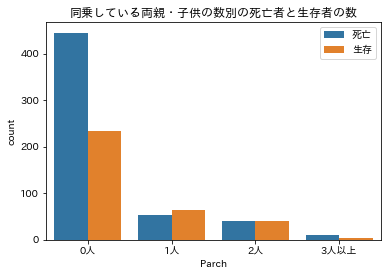

Survived             0    1
Parch_0_1_2_3over          
0                  445  233
1                   53   65
2                   40   40
3                   11    4

Survived                  0         1
Parch_0_1_2_3over                    
0                  0.656342  0.343658
1                  0.449153  0.550847
2                  0.500000  0.500000
3                  0.733333  0.266667

In [22]:
# 2以下であればそのままの数、3以上は3という変換を行う
train['Parch_0_1_2_3over'] = [i if i <=2 else 3 for i in train['Parch']]
# Parch_0_1_2_3overごとに集計し可視化
sns.countplot(x='Parch_0_1_2_3over',hue='Survived', data=train)
plt.title('同乗している両親・子供の数別の死亡者と生存者の数')
plt.legend(['死亡','生存'])
plt.xticks([0, 1, 2, 3], ['0人', '1人', '2人', '3人以上'])
plt.xlabel('Parch')
plt.show()
# ParchとSurvivedをクロス集計する
display(pd.crosstab(train['Parch_0_1_2_3over'], train['Survived']))
# クロス集計しParchごとに正規化する
display(pd.crosstab(train['Parch_0_1_2_3over'], train['Survived'],
normalize='index')) 

In [23]:
# ParchとSurvivedをクロス集計する
display(pd.crosstab(train['Parch_0_1_2_3over'], train['Survived']))

# クロス集計しParchごとに正規化する
display(pd.crosstab(train['Parch_0_1_2_3over'], train['Survived'], normalize='index'))

Survived             0    1
Parch_0_1_2_3over          
0                  445  233
1                   53   65
2                   40   40
3                   11    4

Survived                  0         1
Parch_0_1_2_3over                    
0                  0.656342  0.343658
1                  0.449153  0.550847
2                  0.500000  0.500000
3                  0.733333  0.266667

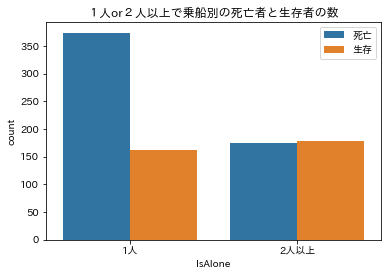

In [24]:
#SibSpとParchが同乗している家族の数。1を足すと家族の人数となる
train['FamilySize']=train['SibSp']+ train['Parch']+ 1

# IsAloneを0とし、2行目でFamilySizeが2以上であれば1にしている
train['IsAlone'] = 0
train.loc[train['FamilySize'] >= 2, 'IsAlone'] = 1

# IsAloneごとに可視化
sns.countplot(x='IsAlone', hue = 'Survived', data = train)
plt.xticks([0, 1], ['1人', '2人以上'])

plt.legend(['死亡', '生存'])
plt.title('１人or２人以上で乗船別の死亡者と生存者の数')
plt.show()

In [25]:
# IsAloneとSurvivedをクロス集計する
display(pd.crosstab(train['IsAlone'], train['Survived']))

# クロス集計しIsAloneごとに正規化する
display(pd.crosstab(train['IsAlone'], train['Survived'], normalize='index'))

Survived    0    1
IsAlone           
0         374  163
1         175  179

Survived         0         1
IsAlone                     
0         0.696462  0.303538
1         0.494350  0.505650

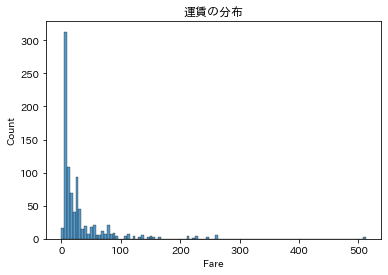

In [26]:
sns.histplot(train['Fare'].dropna(), kde=False)
plt.title('運賃の分布');

In [27]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

# CategoricalFareとSurvivedをクロス集計する
display(pd.crosstab(train['CategoricalFare'], train['Survived']))

# クロス集計しCategoricalFareごとに正規化する
display(pd.crosstab(train['CategoricalFare'], train['Survived'], normalize='index'))

Survived           0    1
CategoricalFare          
(-0.001, 7.91]   179   44
(7.91, 14.454]   156   68
(14.454, 31.0]   121  101
(31.0, 512.329]   93  129

Survived                0         1
CategoricalFare                    
(-0.001, 7.91]   0.802691  0.197309
(7.91, 14.454]   0.696429  0.303571
(14.454, 31.0]   0.545045  0.454955
(31.0, 512.329]  0.418919  0.581081

In [28]:
train['Name'][0:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [29]:
# 敬称を抽出し、重複を省く
set(train.Name.str.extract(' ([A-Za-z]+)\.', expand=False))


{'Capt',
 'Col',
 'Countess',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir'}

In [30]:
# 敬称をcountする
train.Name.str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Don           1
Lady          1
Ms            1
Mme           1
Jonkheer      1
Countess      1
Sir           1
Capt          1
Name: Name, dtype: int64

In [31]:
# df_trainにTitle列を作成、Title列の値は敬称
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# df_trainのTitle列の値ごとに平均値を算出
train.groupby('Title').mean()['Age']

Title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64

In [32]:
# 変換するための関数を作成
def title_to_num(title):
    if title == 'Master':
        return 1
    elif title == 'Miss':
        return 2
    elif title == 'Mr':
        return 3
    elif title == 'Mrs':
        return 4
    else:
        return 5

# testにもtitle列を作成
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# リスト内包表記を用いて変換
train['Title_num'] = [title_to_num(i) for i in train['Title']]
test['Title_num'] = [title_to_num(i) for i in test['Title']]

In [33]:
# SexとEmbarkedのOne-Hotエンコーディング
train = pd.get_dummies(train, columns=['Sex', 'Embarked'])
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

In [34]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare Cabin  ... FamilySize  IsAlone  CategoricalFare  \
0         A/5 21171   7.2500   NaN  ...          2        1   (-0.001, 7.91]   
1          PC 17599  71.2833   C85  ...          2        1  (31.0, 512.329]   
2  STON/O2. 3101282   7.9250   NaN  ...          1        0   (7.91, 14.454]   
3            113803  53.1000  C123  ...          2        1  (31.0, 512.329]   
4            373450   8.0500   NaN  ...          1        0   (7.91, 14.454]   

   Title  Title_num Sex_female Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0     Mr          3          0        1           0           0           1  
1    Mrs          4          1        0           1           0           0  
2   Miss          2          1        0           0           0           1  
3    Mrs          4          1        0           0           0           1  
4     Mr          3          0        1           0           0           1  

[5 rows x 23 columns]

In [35]:
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Title'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Title'], axis=1, inplace=True) 

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Survived           891 non-null    int64   
 1   Pclass             891 non-null    int64   
 2   Age                714 non-null    float64 
 3   SibSp              891 non-null    int64   
 4   Parch              891 non-null    int64   
 5   Fare               891 non-null    float64 
 6   CategoricalAge     714 non-null    category
 7   SibSp_0_1_2over    891 non-null    int64   
 8   Parch_0_1_2_3over  891 non-null    int64   
 9   FamilySize         891 non-null    int64   
 10  IsAlone            891 non-null    int64   
 11  CategoricalFare    891 non-null    category
 12  Title_num          891 non-null    int64   
 13  Sex_female         891 non-null    uint8   
 14  Sex_male           891 non-null    uint8   
 15  Embarked_C         891 non-null    uint8   
 16  Embarked

In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         332 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        417 non-null    float64
 5   Title_num   418 non-null    int64  
 6   Sex_female  418 non-null    uint8  
 7   Sex_male    418 non-null    uint8  
 8   Embarked_C  418 non-null    uint8  
 9   Embarked_Q  418 non-null    uint8  
 10  Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 21.8 KB
